<h2>Task 1: Configuration Space</h2>
<h3>A. Visualize from the given data the workspace and the different rod configurations for each discretized
orientation. Comment on the given discretized values for orientation.</h3>

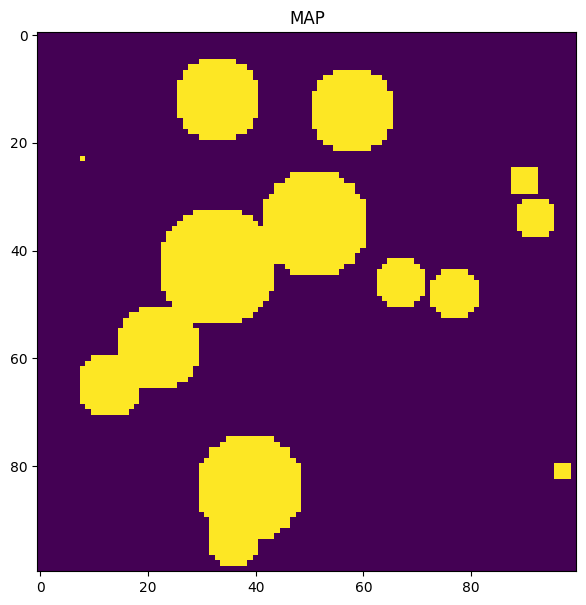

In [2]:
import numpy as np
import matplotlib.pyplot as plt
ps1 = np.load('data_ps1.npz')
rod = ps1["rod"]
env = ps1["environment"]
plt.figure(figsize=(7,7))
plt.imshow(env)
plt.title('MAP')
plt.show()

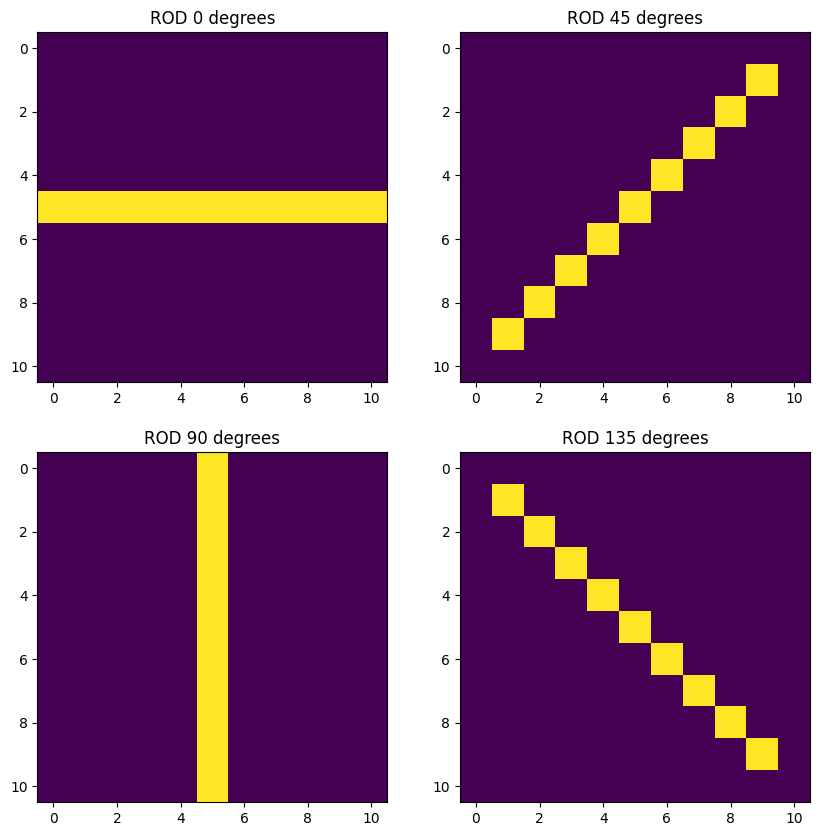

In [3]:
plt.figure(figsize=(10,10))
for i in range (4):
    plt.subplot(2,2,i+1)
    plt.imshow(rod[:,:,i])
    plt.title(f'ROD {i*45} degrees')
plt.show()

<h3>B. Visualize the environment together with the object</h3>

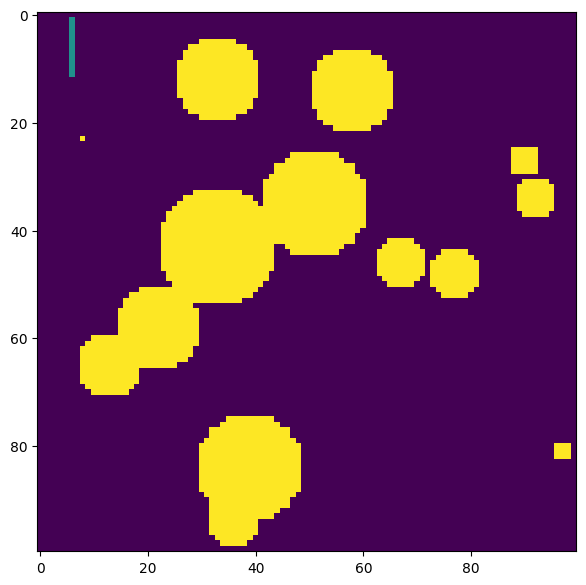

In [4]:
def plot_enviroment(img: np.ndarray, obj: np.ndarray, state: tuple):
    """
    @param img: original image in 2d
    @param obj: is the 3d array of different configurations
    @param state: is the curent pose (x, y, orientation) of the object

    @return: the merged image
    """
    dims = obj.shape
    dim_x = int((dims[0] - 1) / 2)
    dim_y = int((dims[1] - 1) / 2)
    merged_img = np.copy(img)
    merged_img[state[0] - dim_x:state[0] + dim_x + 1, state[1] - dim_y:state[1] + dim_y + 1] += obj[:, :, state[2]] * 0.5
    return merged_img
plt.figure(figsize=(7,7))
plt.imshow(plot_enviroment(env,rod,(6,6,2)))
plt.show()

<h3>C. Create the C-space for the 2D environment map. For this, plot all the images corresponding to each
of the orientations by using collision checking.</h3>

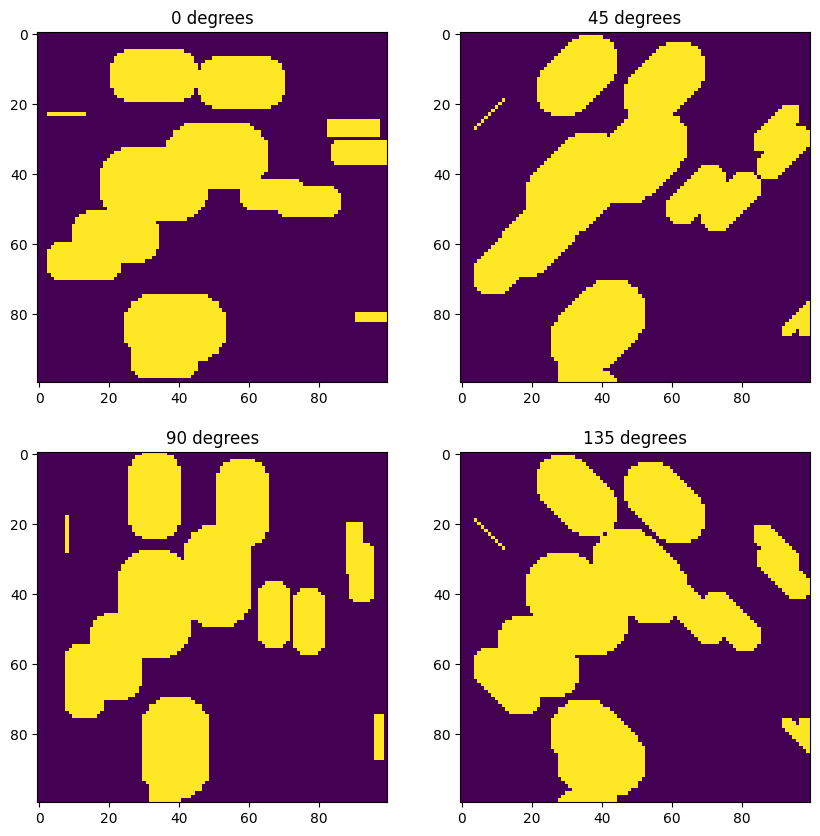

In [5]:
from scipy import signal
def normalize_image(img: np.ndarray, threshold: float = 0.1):
    """
    normalize the image to be between 0 and 1
    """
    dims = img.shape
    env = np.ones(dims)
    z = np.where(img < threshold)
    env[z] = 0.0
    return env
plt.figure(figsize=(10,10))
Cmap = np.zeros((4,100,100))
for i in range (4):
    plt.subplot(2,2,i+1)
    conv = signal.convolve2d(env, rod[:,:,i], boundary='symm', mode='same')
    plt.imshow(normalize_image(conv))
    plt.title(f'{i*45} degrees')
    Cmap[i,:,:] += normalize_image(conv)[:,:]
plt.show()

<h3> D. Comment on the obtained C-space with the previous method. What is the size of the C-space? </h3>

The obtained C-space is used to check explicitly for collisions on all configurations, with 2D convolutions of the object against the obstacle.  

In [5]:
print(Cmap[:,:,:].shape)

(4, 100, 100)


The size of C-space is $100 \times 100$ with 4 dimensions

<h2>Task 2: A star Algorithm</h2>

<h3>A. Implement the A star algorithm and plan in the generated discrete C-space from the previous task. The starting configuration of the agent is (6,6,2) and the goal configuration is (55,55,0). On this first iteration, use an heuristic function h(q, qG) = 0, which is equivalent to the Dijkstra algorithm.
Save the result of calculated plan in rod_solve.mp4 using plotting_result(environment,rod,plan)
from utils.py, where plan is list of rod states from start to goal.</h3>

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera
class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


def astar(maze, cmap, start, end):
    """Returns a list of tuples as a path from the given start to the given end in the given maze"""

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1] # Return reversed path 

        # Generate children
        children = []
        for new_position in [(1,0,0), (-1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]: # moving up, down, left, right, rotate right, rotate left

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1],current_node.position[2] + new_position[2])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0 or node_position[2] > 3 or node_position[2] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue
                
            # Make sure not collise
            if cmap[node_position[2]][node_position[0]][node_position[1]] != 0:
                continue 
                     
            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = 0
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)
def plotting_results(environment: np.ndarray, rod: np.ndarray, plan: list, save_path: str = 'rod_solve.gif'):
    """
    create an animation of the plan and save it to a file

    @param environment: the environment image in 2d
    @param rod: is the 3d array of different configuration
    @param plan: list of poses
    @param save_path: path to save the animation
    """

    fig = plt.figure()
    imgs = []

    for s in plan:
        im = plot_enviroment(environment, rod, s)
        plot = plt.imshow(im)
        imgs.append([plot])

    ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True)

    ani.save(save_path)

    plt.show()
def main():
    
    start = (6,6,2)
    end = (55,55,0)
    plan = astar(env, Cmap, start, end)
    print(plan)
    print("The final cost is", len(plan))
    plotting_results(env, rod, plan)
    
if __name__ == '__main__':
    main()

<h3> B. Change the heuristic function now to be h(q, qG) = L1 norm of the x, y components. Comment on
the changes, how many states have been visited compared to Dijkstra? What is the final cost?
Comment on the results.</h3>

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera
class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


def astar(maze, cmap, start, end):
    """Returns a list of tuples as a path from the given start to the given end in the given maze"""

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1] # Return reversed path 

        # Generate children
        children = []
        for new_position in [(1,0,0), (-1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]: # moving up, down, left, right, rotate right, rotate left

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1],current_node.position[2] + new_position[2])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0 or node_position[2] > 3 or node_position[2] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue
                
            # Make sure not collise
            if cmap[node_position[2]][node_position[0]][node_position[1]] != 0:
                continue 
                     
            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = abs(child.position[0] - end_node.position[0]) + abs(child.position[1] - end_node.position[1]) + abs(child.position[2] - end_node.position[2])
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)
def plotting_results(environment: np.ndarray, rod: np.ndarray, plan: list, save_path: str = 'rod_solve.gif'):
    """
    create an animation of the plan and save it to a file

    @param environment: the environment image in 2d
    @param rod: is the 3d array of different configuration
    @param plan: list of poses
    @param save_path: path to save the animation
    """

    fig = plt.figure()
    imgs = []

    for s in plan:
        im = plot_enviroment(environment, rod, s)
        plot = plt.imshow(im)
        imgs.append([plot])

    ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True)

    ani.save(save_path)

    plt.show()
def main():
    
    start = (6,6,2)
    end = (55,55,0)
    plan = astar(env, Cmap, start, end)
    print(plan)
    print("The final cost is", len(plan))
    plotting_results(env, rod, plan)
    
if __name__ == '__main__':
    main()

Dijkstra and A* algorithm return the same path, but Dijkstra takes longer time than A*. 
The cost is 125.

<h3>C. Propose an heuristic function h(q, qG) that includes orientation. Compare metrics with the previous
results. Comment on the results</h3>

The heuristic function can be changed to $h(q, q_G) = L2 norm$
$$h(q, q_G) = L2 norm = \sqrt{(x_{cur}-x_{goal})^{2}+(y_{cur}-y_{goal})^{2}}$$
where
- $h(q, q_G)$ is a heuristic function; 
- $x_{cur},y_{cur}$ - coordinates of current point
- $x_{goal},y_{goal}$ - coordinates of goal point

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera
class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


def astar(maze, cmap, start, end):
    """Returns a list of tuples as a path from the given start to the given end in the given maze"""

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1] # Return reversed path 

        # Generate children
        children = []
        for new_position in [(1,0,0), (-1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]: # moving up, down, left, right, rotate right, rotate left

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1],current_node.position[2] + new_position[2])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0 or node_position[2] > 3 or node_position[2] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue
                
            # Make sure not collise
            if cmap[node_position[2]][node_position[0]][node_position[1]] != 0:
                continue 
                     
            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2) + ((child.position[2] - end_node.position[2]) ** 2)
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)
def plotting_results(environment: np.ndarray, rod: np.ndarray, plan: list, save_path: str = 'rod_solve.gif'):
    """
    create an animation of the plan and save it to a file

    @param environment: the environment image in 2d
    @param rod: is the 3d array of different configuration
    @param plan: list of poses
    @param save_path: path to save the animation
    """

    fig = plt.figure()
    imgs = []

    for s in plan:
        im = plot_enviroment(environment, rod, s)
        plot = plt.imshow(im)
        imgs.append([plot])

    ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True)

    ani.save(save_path)

    plt.show()
def main():
    
    start = (6,6,2)
    end = (31,61,0)
    plan = astar(env, Cmap, start, end)
    print(plan)
    print("The final cost is", len(plan))
    plotting_results(env, rod, plan)
    
if __name__ == '__main__':
    main()

Using heuristic function with $L2 norm$ decreases the running time. Conclude, heuristic function plays an important role in the A* algorithm, helping to find the goal faster. Of the three types $h = 0, h = L1 norm$ and $h = L2 norm, L2 norm$ runs the fastest and most efficiently in this problem.

Beside that, we can consider this method: <br>
$$h(m,n,t,goal,p)=[w_{0}+w_{1}h_{1}(m,n,t)+w_{2}h_{2}(p,m,n)](h_{0}(n,goal))$$
where 
- h(m,n,t,goal,p) is a heuristic function; 
- m - starting grid point; 
- n - current neighbor;
- t steps explored in the forward direction; 
- goal - goal grid point; 
- p - previous explored node 
- $h_{0}(n,goal)=\|n-goal\|^2$ 
- $h_{1}(m,n,t)=1$ or $0$ - is a binary variable that is 1 if moving from m for t steps along the direction of m contains an obstacle. <br>
- $h_{2}(m,n,t)=1$ or $0$ - is a binary variable that is 0 if p, m and n of the vehicle’s previous heading and the next are in the same direction, and 1 if they are not aligned. <br>
- The weights $w_0, w_1$ predict the possibility for a turn and therefore avoids that path altogether.